In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

path_data = r"C:\Users\Perydox\Desktop\Proyecto_Grado\data"


In [3]:
atenciones = pd.read_csv(
    os.path.join(path_data, "atenciones.csv"),
    header=None,
    names=['atencion_id','paciente_id','tratamiento_id','fecha','forma_pago','estado_pago','observaciones'],
    parse_dates=['fecha']
)
tratamientos = pd.read_csv(
    os.path.join(path_data, "tratamientos.csv"),
    header=None,
    names=['tratamiento_id','nombre','area_id','precio'],
    dtype={'precio': float}
)
display(atenciones.head(), tratamientos.head())


,atencion_id,paciente_id,tratamiento_id,fecha,forma_pago,estado_pago,observaciones
0,1,319,9,2021-01-01,Efectivo,Pagado,NaN
1,2,319,7,2021-01-01,Efectivo,Pagado,NaN
2,3,112,4,2021-01-01,Efectivo,Pagado,NaN
3,4,39,9,2021-01-01,Efectivo,Pagado,NaN
4,5,338,15,2021-01-01,Efectivo,Pendiente,NaN


,tratamiento_id,nombre,area_id,precio
0,1,Consulta General,1,200.0
1,2,Limpieza Dental,1,250.0
2,3,Tratamiento de Caries,1,400.0
3,4,Colocación de Brackets,2,3000.0
4,5,Mantenimiento de Ortodoncia,2,500.0


In [4]:
df = atenciones.merge(
    tratamientos[['tratamiento_id','precio']],
    on='tratamiento_id', how='left'
)
df['ingreso'] = np.where(df['estado_pago']=="Pagado", df['precio'], 0.0)


In [5]:
df['anio'] = df['fecha'].dt.year
df['mes']  = df['fecha'].dt.month

agg = df.groupby(['anio','mes']).agg(
    ingreso_total     = ('ingreso','sum'),
    total_atenciones  = ('atencion_id','count'),
    pacientes_unicos  = ('paciente_id', pd.Series.nunique),
    pct_pagado        = ('estado_pago', lambda s: np.mean(s=="Pagado"))
).reset_index()

agg['fecha_mes'] = pd.to_datetime(
    agg['anio'].astype(str) + '-' +
    agg['mes'].astype(str).str.zfill(2) + '-01'
)
agg = agg.sort_values('fecha_mes').reset_index(drop=True)
display(agg.head())


,anio,mes,ingreso_total,total_atenciones,pacientes_unicos,pct_pagado,fecha_mes
0,2021,1,627770.0,436,284,0.954128,2021-01-01
1,2021,2,569150.0,411,281,0.941606,2021-02-01
2,2021,3,753160.0,562,337,0.939502,2021-03-01
3,2021,4,817720.0,553,327,0.945750,2021-04-01
4,2021,5,633720.0,481,306,0.941788,2021-05-01


In [6]:
df_m = agg.copy()
df_m['sin_mes']   = np.sin(2*np.pi * (df_m['mes']-1)/12)
df_m['cos_mes']   = np.cos(2*np.pi * (df_m['mes']-1)/12)
df_m['anio_cent'] = df_m['anio'] - df_m['anio'].min()

df_m = df_m.sort_values('fecha_mes')
df_m['lag1'] = df_m['ingreso_total'].shift(1)
df_m['lag2'] = df_m['ingreso_total'].shift(2)
df_m['ma3']  = df_m['ingreso_total'].rolling(3).mean().shift(1)

for c in ['lag1','lag2','ma3']:
    df_m[c].fillna(df_m[c].mean(), inplace=True)

display(df_m.tail())


C:\Users\Perydox\AppData\Local\Temp\ipykernel_24020\3941495838.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_m[c].fillna(df_m[c].mean(), inplace=True)


,anio,mes,ingreso_total,total_atenciones,pacientes_unicos,pct_pagado,fecha_mes,sin_mes,cos_mes,anio_cent,lag1,lag2,ma3
43,2024,8,164300.0,124,107,0.935484,2024-08-01,-0.500000,-8.660254e-01,3,382260.0,454050.0,498693.333333
44,2024,9,101230.0,76,69,0.973684,2024-09-01,-0.866025,-5.000000e-01,3,164300.0,382260.0,333536.666667
45,2024,10,104600.0,82,77,0.963415,2024-10-01,-1.000000,-1.836970e-16,3,101230.0,164300.0,215930.000000
46,2024,11,211960.0,151,137,0.960265,2024-11-01,-0.866025,5.000000e-01,3,104600.0,101230.0,123376.666667
47,2024,12,381670.0,250,195,0.960000,2024-12-01,-0.500000,8.660254e-01,3,211960.0,104600.0,139263.333333


In [7]:
n_test = 6
train = df_m.iloc[:-n_test].reset_index(drop=True)
test  = df_m.iloc[-n_test:].reset_index(drop=True)

features = [
    'total_atenciones','pacientes_unicos','pct_pagado',
    'sin_mes','cos_mes','anio_cent','lag1','lag2','ma3'
]
X_train, y_train = train[features], train['ingreso_total']
X_test,  y_test  = test[features],  test['ingreso_total']

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (42, 9) Test: (6, 9)


In [8]:
model = RandomForestRegressor(
    n_estimators=200,
    min_samples_leaf=4,
    random_state=42
)
model.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=4, n_estimators=200, random_state=42)

R²:   0.9223
MAE:  26337.23
MSE:  1074271297.07
RMSE: 32776.08


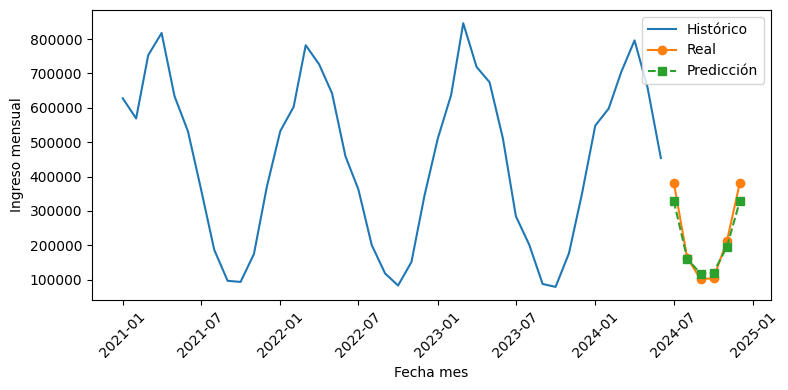

In [9]:
y_pred = model.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(8,4))
plt.plot(train['fecha_mes'], train['ingreso_total'], label='Histórico')
plt.plot(test['fecha_mes'], y_test, 'o-', label='Real')
plt.plot(test['fecha_mes'], y_pred, 's--', label='Predicción')
plt.xlabel('Fecha mes'); plt.ylabel('Ingreso mensual')
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


Evaluación últimos 6 meses (test):
R²:   0.9223
MAE:  26337.23
MSE:  1074271297.07
RMSE: 32776.08


,fecha_mes,pred_ingreso
0,2025-01-01,529083.764277
1,2025-02-01,608698.286420
2,2025-03-01,762948.592132
3,2025-04-01,761184.650882
4,2025-05-01,646400.842041
5,2025-06-01,518031.200488


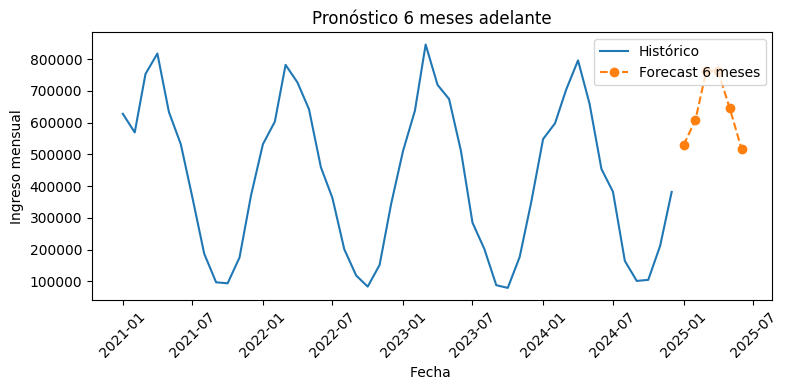

In [ ]:

n_test = 6
test   = df_m.iloc[-n_test:].copy()
X_test = test[features]
y_test = test['ingreso_total']   
y_pred = model.predict(X_test)

r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Evaluación últimos 6 meses (test):")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# 2) Forecast para los próximos 6 meses
start_forecast = df_m['fecha_mes'].max() + pd.offsets.MonthBegin()
futuro6 = pd.date_range(start_forecast, periods=6, freq='MS')

# Promedios históricos exógenos
mes_prom = df_m.groupby(df_m['fecha_mes'].dt.month)[
    ['total_atenciones','pacientes_unicos','pct_pagado']
].mean()

hist = df_m['ingreso_total'].tolist()
preds6 = []

for fecha in futuro6:
    m = fecha.month
    sin_mes   = np.sin(2 * np.pi * (m-1) / 12)
    cos_mes   = np.cos(2 * np.pi * (m-1) / 12)
    anio_cent = fecha.year - df_m['anio'].min()
    ta, pu, pp = mes_prom.loc[m]
    lag1 = hist[-1]
    lag2 = hist[-2]
    ma3  = np.mean(hist[-3:])
    Xf = pd.DataFrame([[
        ta, pu, pp,
        sin_mes, cos_mes, anio_cent,
        lag1, lag2, ma3
    ]], columns=features)
    yhat = model.predict(Xf)[0]
    preds6.append((fecha, yhat))
    hist.append(yhat)


df_forecast6 = pd.DataFrame({
    'fecha_mes': [f for f,_ in preds6],
    'pred_ingreso': [y for _,y in preds6]
})
display(df_forecast6)

plt.figure(figsize=(8,4))
plt.plot(df_m['fecha_mes'], df_m['ingreso_total'], label='Histórico')
plt.plot(df_forecast6['fecha_mes'], df_forecast6['pred_ingreso'], 'o--', label='Forecast 6 meses')
plt.xlabel('Fecha mes')
plt.ylabel('Ingreso mensual')
plt.title('Pronóstico 6 meses adelante')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'rf_mensual.pkl')
print("Modelo mensual guardado en rf_mensual.pkl")


Modelo mensual guardado en rf_mensual.pkl
